In [1]:
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../CODE/')
from importlib import reload
import visualization_utils
reload(visualization_utils)
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

### Fig. 2B: Feature overall contributions for responsive vs unresponsive targets under Yeast TF Lys14 perturbation
- Left: For yeast TF Lys14, the positive (red) or negative (blue) SHAP values for each feature, summed over genomic positions relative to each gene and averaged over genes that respond to Lys14 perturbation. 
- Right: The same analysis for genes that do not respond to Lys14 perturbation.

In [2]:
organism = 'yeast'
tf_name = 'YDR034C'
tf_dir = '../OUTPUT/Yeast_cc_zev/all_feats/xgb/{}'.format(tf_name)

sss_df = calculate_resp_and_unresp_signed_shap_sum(tf_dir, tf_name, organism)

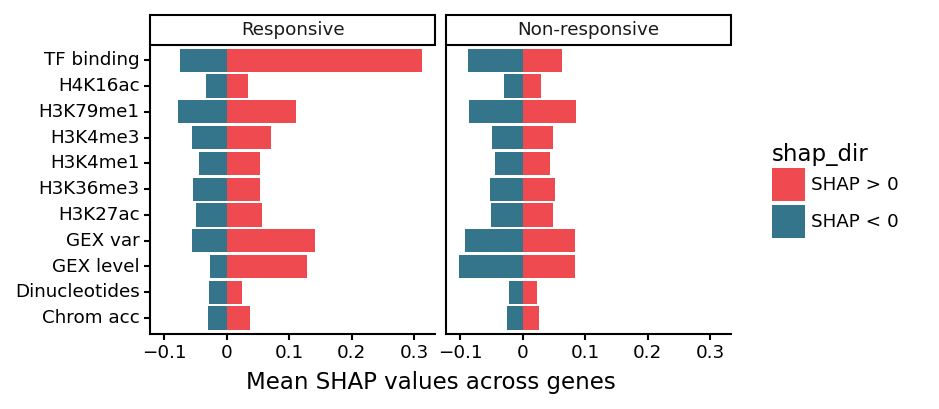

<ggplot: (-9223372029841473753)>

In [3]:
ax = (
    ggplot(sss_df, aes(x='feat_type_name', y='shap', fill='shap_dir'))
    + geom_bar(stat='identity', alpha=.8)
    + scale_fill_manual([COLORS['red'], COLORS['dark_blue']])
    + coord_flip()
    + facet_wrap('label_name')
    + labs(x=None, y='Mean SHAP values across genes')
    + theme_classic()
    + theme(
        figure_size=(5, 2.5), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 2C: Net influence of yeast features
- Distribution across TFs of the “net influence” of each feature on predictions, averaged over responsive targets. 
- Net influence is the sum of all SHAP values for a feature, regardless of sign or genomic position.

In [4]:
organism = 'yeast'
cc_dir = '../OUTPUT/Yeast_cc_zev/all_feats/xgb/'
chipexo_dir = '../OUTPUT/Yeast_chipexo_zev/all_feats/xgb/'
tf_names = np.union1d(
    np.loadtxt('../RESOURCES/Yeast_CallingCards_TFs.txt', dtype=str),
    np.loadtxt('../RESOURCES/Yeast_ChIPexo_TFs.txt', dtype=str))

sss_df_list = []

for tf_name in tf_names:
    try:
        tf_dir, is_cc, acc = get_best_yeast_model((cc_dir, chipexo_dir), tf_name)
        print('... working on', tf_dir)
        
        sss_df = calculate_resp_and_unresp_signed_shap_sum(tf_dir, tf_name, organism)
        sss_df['tf'] = tf_name
        sss_df['acc'] = acc
        sss_df_list.append(sss_df)
        
    except:
        print('TF {} not available in Calling Cards or ChIP-exo'.format(tf_name))

sss_tfs_df = pd.concat(sss_df_list)
sss_tfs_df = calculate_shap_net_influence(sss_tfs_df)

... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YAL051W
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YBL103C
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YBR239C
... working on ../OUTPUT/Yeast_cc_zev/all_feats/xgb//YDR034C
TF YDR123C not available in Calling Cards or ChIP-exo
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YEL009C
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YGL162W
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YHR178W
... working on ../OUTPUT/Yeast_cc_zev/all_feats/xgb//YIL036W
... working on ../OUTPUT/Yeast_cc_zev/all_feats/xgb//YJL056C
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YJL089W
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YJR060W
... working on ../OUTPUT/Yeast_cc_zev/all_feats/xgb//YKL038W
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YLR256W
... working on ../OUTPUT/Yeast_cc_zev/all_feats/xgb//YLR403W
... working on ../OUTPUT/Yeast_cc_zev/all_feats

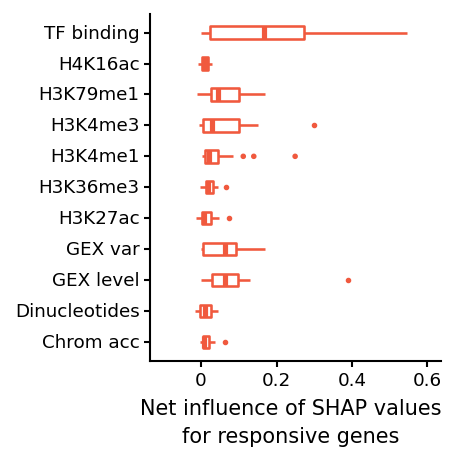

<ggplot: (-9223372029845214292)>

In [5]:
# Only plot models with AUPRC > 0.1
plot_df = sss_tfs_df[(sss_tfs_df['acc'] > .1) & (sss_tfs_df['label_name'] == 'Responsive')]

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
    + coord_flip()
    + ylim(-.1, .6)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)

### Fig. 2E: Net influence of human K562 features
- Distribution across TFs of the “net influence” of each feature on predictions, averaged over responsive targets. 
- Net influence is the sum of all SHAP values for a feature, regardless of sign or genomic position.

In [6]:
organism = 'human'
data_dir = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb/all_feats/xgb/'
tf_names = np.loadtxt('../RESOURCES/Human_ENCODE_K562_TFs.txt', dtype=str, usecols=[0])

sss_df_list = []

for tf_name in tf_names:
    tf_dir = '{}/{}'.format(data_dir, tf_name)
    try:
        acc = pd.read_csv('{}/stats.csv.gz'.format(tf_dir))['auprc'].median()
        print('... working on', tf_name)

        sss_df = calculate_resp_and_unresp_signed_shap_sum(tf_dir, tf_name, organism)
        sss_df['tf'] = tf_name
        sss_df['acc'] = acc
        sss_df_list.append(sss_df)
        
    except:
        print('TF {} not available in human K562'.format(tf_name))

sss_tfs_df = pd.concat(sss_df_list)
sss_tfs_df = calculate_shap_net_influence(sss_tfs_df)

TF ENSG00000116017 not available in human K562
... working on ENSG00000162772
... working on ENSG00000156273
TF ENSG00000134107 not available in human K562
... working on ENSG00000115816
TF ENSG00000102974 not available in human K562
TF ENSG00000205250 not available in human K562
TF ENSG00000169016 not available in human K562
... working on ENSG00000105722
... working on ENSG00000141568
... working on ENSG00000111206
... working on ENSG00000102145
... working on ENSG00000179348
... working on ENSG00000172273
... working on ENSG00000147421
TF ENSG00000118418 not available in human K562
... working on ENSG00000130522
TF ENSG00000197063 not available in human K562
TF ENSG00000198517 not available in human K562
TF ENSG00000125952 not available in human K562
TF ENSG00000103495 not available in human K562
... working on ENSG00000134138
... working on ENSG00000187098
TF ENSG00000119950 not available in human K562
... working on ENSG00000082641
... working on ENSG00000001167
... working on ENS

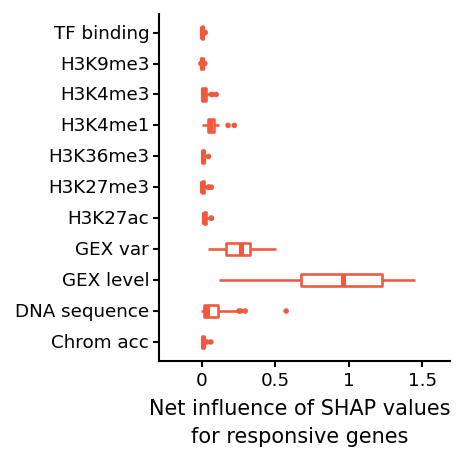

<ggplot: (-9223372029843789361)>

In [14]:
# Only plot models with AUPRC > 0.1
plot_df = sss_tfs_df[(sss_tfs_df['acc'] > .1) & (sss_tfs_df['label_name'] == 'Responsive')]

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
    + coord_flip()
    + ylim(-.2, 1.6)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)